In [85]:
from collections import namedtuple
from enum import Enum
import json
import os

import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import music21
import numpy as np
import pandas as pd

# Utilities

## Constants

In [90]:
SIG_DIGITS = 4
QUANTIZATION = 12  # smallest unit is 1/12 of a beat
MAX_EVENT_BEATS = 4

MIDI_MIN = 21
MIDI_MAX = 108

MAX_EVENT_SUBBEATS = QUANTIZATION * MAX_EVENT_BEATS

MIDI_LEN = MIDI_MAX - MIDI_MIN + 1  # 88 keys

# One-hot vector lengths
NUM_COMMAND_CLASSES = 3
NUM_MIDI_CLASSES = MIDI_LEN + 1                # + 1 for "0" case
NUM_DURATION_CLASSES = MAX_EVENT_SUBBEATS + 1  # + 1 for "0" case

## Key

In [4]:
class KeyQuality(Enum):
    Major = 0,
    Minor = 1

In [5]:
STR_TO_PITCH_CLASS = {
    'C': 0,
    'B#': 0,
    'C#': 1,
    'DB': 1,
    'D': 2,
    'D#': 3,
    'EB': 3,
    'E': 4,
    'FB': 4,
    'F': 5,
    'F#': 6,
    'GB': 6,
    'G': 7,
    'G#': 8,
    'AB': 8,
    'A': 9,
    'A#': 10,
    'BB': 10,
    'B': 11,
    'CB': 11
}

STR_TO_MODE = {
    'MAJOR': KeyQuality.Major,
    'MINOR': KeyQuality.Minor
}

In [6]:
def parse_key_string(str_key):
    """Returns a tuple of root pitch class (int, 0=C to 11=B) and KeyQuality."""
    tokens = str_key.strip().upper().split(' ')
    if len(tokens) != 2:
        raise Exception("Can't parse key: %s" % str_key)
    pitch_str, mode_str = tokens
    pc = STR_TO_PITCH_CLASS[pitch_str]
    mode = STR_TO_MODE[mode_str]
    return pc, mode    

## Time

In [34]:
def get_timeshift_set(score):
    s = set()
    for _, event_type, _, time_delta in score:
        if event_type == ScoreEventType.TimeShift:
            s.add(time_delta)
    return s

Dataset is quantized to 1/12 of a quarter note (48th notes)

In [195]:
class Duration():
    def __init__(self, beats, subbeats, quantization=QUANTIZATION):
        self.beats = beats
        self.subbeats = subbeats
        self.quantization = quantization
    
    def total_subbeats(self):
        return self.beats * self.quantization + self.subbeats
    
    def subtract_subbeats(self, subbeats):
        """Modify the duration by subtracting the given # of subbeats."""
        # Find the total # of full beats to subtract.
        beats_to_subtract = subbeats // QUANTIZATION    # int part
        subbeats_to_subtract = subbeats % QUANTIZATION  # fractional part
        
        self.beats -= beats_to_subtract
        self.subbeats -= subbeats_to_subtract         # might be negative now
        
        # Borrow 1 from beats, just like in by-hand subtraction
        if self.subbeats < 0:
            self.subbeats += QUANTIZATION
            self.beats -= 1
        
    @staticmethod
    def MakeDuration(float_duration, quantization=QUANTIZATION):
        beats = int(float_duration)
        subbeats = round((float_duration % 1) * quantization)
        return Duration(beats, subbeats, quantization)
    
    def __repr__(self):
        return 'Duration(%d,%d,%d)' % (self.beats, self.subbeats, self.quantization)

## Score Types

In [17]:
class ScoreEventType(Enum):
    Undefined = -1
    NoteOff = 0
    NoteOn = 1
    TimeShift = 2
    
# In neural net, representation will be: [COMMAND, OPT_MIDI, OPT_TIME_DELTA]
# That is, 3 separate one-hot-encoding blocks, with N/A value possible for MIDI.
# ex:
# [NoteOn, MIDI, 0], [NoteOff, MIDI, 0], [TimeShift, N/A, time_delta]

# MIDI is an int, 0 for N/A or 1-88 representing piano keys 21 to 108
# time_delta will be quantized 1/12 of quarter notes. Duration can be from 0-48 12/th notes.
#    Longer durations will be represented with multiple successive time_shift commands.
    
# time is a float, mostly for output use; not fed into neural net.
# time_delta is a quantized Duration object.
ScoreEvent = namedtuple('ScoreEvent', ['time', 'type', 'midi', 'time_delta'])

In [244]:
def convert_df_to_score(df): # Monophonic
    """The df is an input csv with time, midi, and duration.
    Output is a list of ScoreEvents."""
    
    # Fix durations that are too long and overlap later notes. This is supposed to be
    # monophonic data, but it isn't always.
    for i, row in df.iterrows():
        if i >= len(df) - 1: # skip last row
            break
        time =  row['time']
        next_time = df.loc[i+1, 'time']
        if time + row['duration'] > next_time:
            df.loc[i, 'duration']= next_time - time
        
    events = []
    prev_time = None
    for _, row in df.iterrows():
        time = round(row['time'], SIG_DIGITS)
        midi = int(row['midi'])
        duration = round(row['duration'], SIG_DIGITS)
        
        if prev_time is None:
            prev_time = time
        
        delta_time = round(time - prev_time, SIG_DIGITS)
        
        # Quantize time to beats and subbeats.
        time_quantized = Duration.MakeDuration(time)
        duration_quantized = Duration.MakeDuration(duration)
        delta_time_quantized = Duration.MakeDuration(delta_time)
        
        # Create events.
        #if delta_time_quantized.total_subbeats() > 0:
        # TimeShift.
        events.append(ScoreEvent(prev_time, ScoreEventType.TimeShift, None, delta_time_quantized))
        
        # NoteOn
        events.append(ScoreEvent(time, ScoreEventType.NoteOn, midi, None))
        
        # TimeShift for duration of note
        # DOESN'T WORK if duration is too long for next note. NEEDS PREPROCESSING TO FIX DURs.
        events.append(ScoreEvent(time, ScoreEventType.TimeShift, None, duration_quantized))
        time += duration
        
        # NoteOff
        events.append(ScoreEvent(time, ScoreEventType.NoteOff, midi, None))
        
        prev_time = time
    
    return events            

In [181]:
def score_event_to_nnet_input_list(ev):
    # Output is a list of numpy arrays: 3 one-hot encodings, concatenated.
    # List will usually be 1-element long, but must be multiple for long durations.
    # numpy array has 3 one-hot sections (command, midi, duration)
    # All 3 are concatenated together into ndarray: [command...midi...duration]
    
    _, event_type, midi, time_delta = ev
    result = []
    
    command_vec = to_categorical(event_type.value, num_classes=NUM_COMMAND_CLASSES)
    
    if not midi:
        midi = 0
    else:
        midi = midi - MIDI_MIN + 1
    
    midi_vec = to_categorical(midi, num_classes=NUM_MIDI_CLASSES)  # +1 for the 0 case
    
    if not time_delta:
        time_delta = Duration(0, 0)
    
    # Handle long duration events: repeat them.
    if time_delta.total_subbeats() > MAX_EVENT_SUBBEATS:
        duration_vec = to_categorical(MAX_EVENT_SUBBEATS, num_classes=NUM_DURATION_CLASSES)
        vector = command_vec
        result.append(np.concatenate((command_vec, midi_vec, duration_vec)))
        time_delta.subtract_subbeats(MAX_EVENT_SUBBEATS)
    
    # Regular duration event.
    duration_vec = to_categorical(time_delta.total_subbeats(), num_classes=NUM_DURATION_CLASSES)
    result.append(np.concatenate((command_vec, midi_vec, duration_vec)))
    
    return result

In [182]:
def score_to_array(score):
    arrays_list = []
    for ev in score:
        arrays_list.append(np.array(score_event_to_nnet_input_list(ev)))
    return np.vstack(arrays_list)

In [183]:
def plot_matrix(x):
    plt.figure(figsize=(20,10))
    plt.imshow(x, origin='lower')
    plt.show()

def plot_score(score):
    plot_matrix(score_to_array(score).T)

## MIDI

In [76]:
def get_midi_set(score):
    s = set()
    for _, event_type, midi, _ in score:
        if event_type == ScoreEventType.NoteOn:
            s.add(midi)
    return s

Analysis results -- MIDI in use: notes 21 through 108 (regular piano range)

## File parsing

In [250]:
size = 'medium'   # 'small', medium', 'large'
DATA_PATH = 'data/PPDD-Jul2018_sym_mono_%s/PPDD-Jul2018_sym_mono_%s' % (size, size)

In [251]:
DESCRIPTOR_PATH = os.path.join(DATA_PATH, 'descriptor')       # .json files
PRIME_CSV_PATH = os.path.join(DATA_PATH, 'prime_csv')         # .csv
CONT_FOIL_CSV_PATH = os.path.join(DATA_PATH, 'cont_foil_csv') # .csv
CONT_TRUE_CSV_PATH = os.path.join(DATA_PATH, 'cont_true_csv') # .csv

In [252]:
def get_file_list(path, ext):
    """Returns a list of all files in the given path with the given string ending 'ext'."""
    return [f for f in os.listdir(path) if 
            os.path.isfile(os.path.join(path, f)) and f.endswith(ext)]

In [253]:
descriptor_files = get_file_list(DESCRIPTOR_PATH, 'json')

In [254]:
descriptor_files[:10]

['05b6137d-1d26-4b22-8640-b9bc4d2c0e22.json',
 '5a1d57fb-82a0-4a8a-982a-fd5b7cb9a4be.json',
 '6d70f32c-4d1e-452b-a54f-859f708684c7.json',
 'c279e49d-a0a9-4179-99a0-50bad8809da4.json',
 '99f90f0e-9040-4a9a-bc40-5017e00e919b.json',
 '90f07cc1-8a07-4fdd-b1f9-2e9d0d854f49.json',
 '1a595271-8a93-4d75-ac68-035d93a8b0f9.json',
 '0f9fe2e3-caec-423e-8c2a-aaf20ab23b5f.json',
 '20aa14b9-1f5f-4ffc-90df-1e773fa2c95f.json',
 '7c9153a3-8417-4c64-a438-27f129d5bcd0.json']

# Read Dataset

In [255]:
# all_durations = set()
#all_midi = set()

all_scores = []

for i, json_file in enumerate(descriptor_files):
    if i % 1000 == 0:
        print(i)
    guid = os.path.splitext(json_file)[0]
    #print('Processing file %d: %s' % (i, guid))
    prime_csv_file = os.path.join(PRIME_CSV_PATH, guid) + '.csv'
    
    df_prime = pd.read_csv(prime_csv_file, header=None, 
                           names=['time', 'midi', 'mpn', 'duration', 'channel'])
    score = convert_df_to_score(df_prime)
    all_scores.append(score)
             
    # Used this code to analyze dataset.
    # Result: quantization is to the 1/12 of a beat.
    #all_durations.update(get_timeshift_set(score))
    
    # Result: MIDI notes from 21-108 in use
    #all_midi.update(get_midi_set(score))

    with open(os.path.join(DESCRIPTOR_PATH, descriptor_files[i])) as f:
        j = json.load(f)
        id_lakh = j['idLakh']
        bpm = j['bpm']
        time_sig_numerator, time_sig_denominator = j.get('timeSignature', [4, 4])
        key_estimate = j['keyEstimate']
        
        #print (guid, id_lakh, bpm, time_sig_numerator, time_sig_denominator, key_estimate)
print('Done!')

0
Done!


In [256]:
data = [score_to_array(s) for s in all_scores]

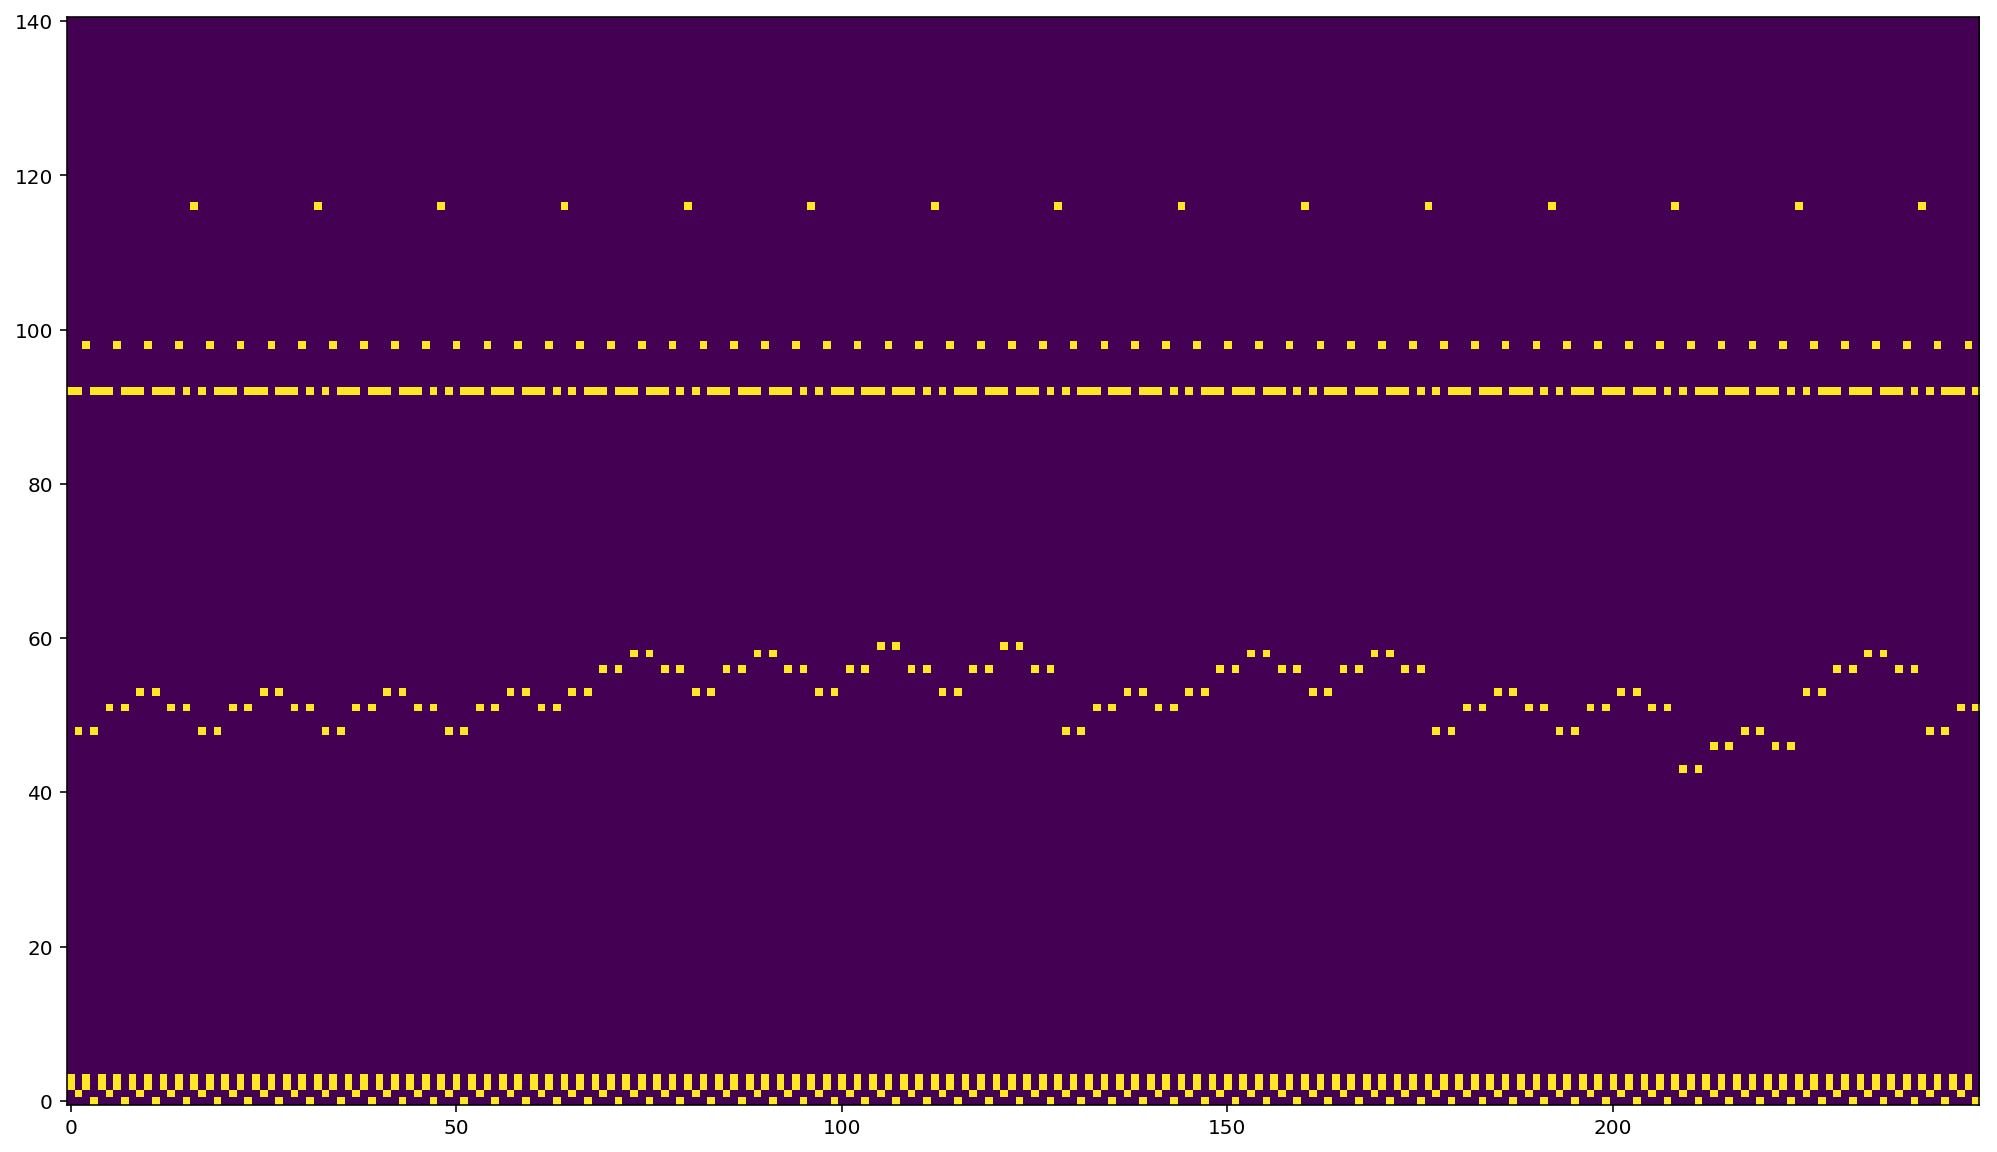

In [257]:
plot_matrix(data[65].T)

In [259]:
len(data)

1000